Excercise 5

Problem 1. Creating a static map showing travel times to Forum within 10 km distance using public transport

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Define file path and read in the polygon grid for metropolitan area
fp = r'data/MetropAccess_YKR_grid_EurefFIN.shp'

grid = gpd.read_file(fp)

In [9]:
grid.head()
print(grid.crs)

epsg:3067


In [6]:
#Read in the travel time data for Forum
fp2 = r'data/TravelTimes_to_5975373_Forum.txt'

data = pd.read_csv(fp2, sep=';')

# Keep only useful columns 
data = data[['pt_r_t', 'pt_r_d','from_id','to_id']]
data.head()
# Rename 'from_id' to 'YKR_ID' to match with grid
data = data.rename(columns={'from_id':'YKR_ID'})
data.head()

,pt_r_t,pt_r_d,YKR_ID,to_id
0,110,32758,5785640,5975373
1,113,32964,5785641,5975373
2,115,33082,5785642,5975373
3,119,33375,5785643,5975373
4,103,32269,5787544,5975373


In [7]:
# Join attributes from data to grid
data_geo = grid.merge(data, how='inner', on='YKR_ID')
data_geo.head()

,x,y,YKR_ID,geometry,pt_r_t,pt_r_d,to_id
0,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",110,32758,5975373
1,382125.0,6697880.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",113,32964,5975373
2,382375.0,6697880.0,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",115,33082,5975373
3,382625.0,6697880.0,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",119,33375,5975373
4,381125.0,6697630.0,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",103,32269,5975373


In [8]:
import numpy as np
# Remove no-data values (i.e. -1) from the data 
# First, replace -1 with 'NaN'
data_geo = data_geo.replace(-1, np.nan)

# Then, drop na rows
data_geo = data_geo.dropna()

# Check there are no no-data values left in the data
data_geo.isna().sum()

x           0
y           0
YKR_ID      0
geometry    0
pt_r_t      0
pt_r_d      0
to_id       0
dtype: int64

In [28]:
print(data_geo.crs)
len(data_geo)


epsg:3067


13020

In [20]:
# Read in shopping center locations
fp3 = r'data/shopping_centers.shp'

SCs= gpd.read_file(fp3)
print(SCs.crs)
SCs.head()


epsg:3879


,address,id,name,addr,geometry
0,"Kauppakeskus Itis, 1-7, Itäkatu, Itäkeskus, Va...",1,Itis,"Itäkatu 1-7, 00930 Helsinki, Finland",POINT (25504598.602 6677662.109)
1,"Apollo Street Bar, 20, Mannerheimintie, Keskus...",2,Forum,"Mannerheimintie 20, 00100 Helsinki, Finland",POINT (25496590.247 6672895.892)
2,"Sports Academy, 11, Piispansilta, Nuottaniemi,...",3,Iso-omena,"Piispansilta 11, 02230 Espoo, Finland",POINT (25485440.532 6672255.563)
3,"Lasten kappeli Arkki, 3-9, Leppävaarankatu, Et...",4,Sello,"Leppävaarankatu 3-9, 02600 Espoo, Finland",POINT (25489491.076 6678322.265)
4,"Stockmann, 3, Vantaanportinkatu, Pakkala, Avia...",5,Jumbo,"Vantaanportinkatu 3, 01510 Vantaa, Finland",POINT (25497943.932 6686656.982)


In [13]:
# Check if coordinate systems of data_geo and SCs match
assert data_geo.crs == SCs.crs, 'Coordinate systems do not match'

AssertionError: Coordinate systems do not match

In [29]:
# Reproject shopping center data to grid coordinate system (EPSG=3067)
SCs = SCs.to_crs(crs=grid.crs)
print(SCs.crs)

# Double check that coordinates match
assert data_geo.crs == SCs.crs, 'Coordinate systems do not match'

epsg:3067


In [31]:
# Take only Forum
forum = SCs.loc[SCs['name'] == 'Forum']
type(forum)

print(forum.crs)
forum = forum.to_crs(crs=data_geo.crs)

# Calculate a 10 km buffer around Forum
forum['buffer'] = forum.buffer(10000)
forum.head()

# Replace point geometry values with buffer values
forum['geometry'] = forum['buffer']

# Create a spatial join between grid layer and buffer layer. 
joined = gpd.sjoin(data_geo, forum, how="inner", op="within")
joined.head()

print(len(joined))

epsg:3067


,x,y,YKR_ID,geometry,pt_r_t,pt_r_d,to_id,index_right,address,id,name,addr,buffer
6747,385625.0,6681880.0,5905734,"POLYGON ((385750.000 6681750.000, 385500.000 6...",45.0,13410.0,5975373.0,1,"Apollo Street Bar, 20, Mannerheimintie, Keskus...",2,Forum,"Mannerheimintie 20, 00100 Helsinki, Finland","POLYGON ((395617.936 6672010.442, 395569.783 6..."
6898,383625.0,6681630.0,5907560,"POLYGON ((383750.000 6681500.000, 383500.000 6...",38.0,11502.0,5975373.0,1,"Apollo Street Bar, 20, Mannerheimintie, Keskus...",2,Forum,"Mannerheimintie 20, 00100 Helsinki, Finland","POLYGON ((395617.936 6672010.442, 395569.783 6..."
6899,383875.0,6681630.0,5907561,"POLYGON ((384000.000 6681500.000, 383750.000 6...",40.0,10923.0,5975373.0,1,"Apollo Street Bar, 20, Mannerheimintie, Keskus...",2,Forum,"Mannerheimintie 20, 00100 Helsinki, Finland","POLYGON ((395617.936 6672010.442, 395569.783 6..."
6900,384125.0,6681630.0,5907562,"POLYGON ((384250.000 6681500.000, 384000.000 6...",46.0,12593.0,5975373.0,1,"Apollo Street Bar, 20, Mannerheimintie, Keskus...",2,Forum,"Mannerheimintie 20, 00100 Helsinki, Finland","POLYGON ((395617.936 6672010.442, 395569.783 6..."
6901,384375.0,6681630.0,5907563,"POLYGON ((384500.000 6681500.000, 384250.000 6...",47.0,11699.0,5975373.0,1,"Apollo Street Bar, 20, Mannerheimintie, Keskus...",2,Forum,"Mannerheimintie 20, 00100 Helsinki, Finland","POLYGON ((395617.936 6672010.442, 395569.783 6..."


<AxesSubplot:>

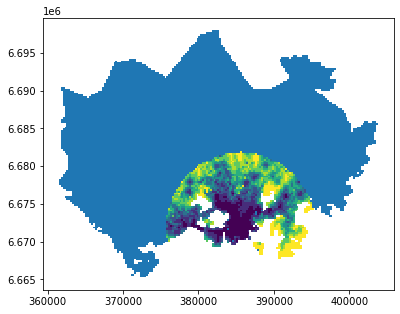

In [38]:
fig, ax=plt.subplots(figsize=(10,5))

grid.plot(ax=ax)
joined.plot(ax=ax,column='pt_r_t', scheme='quantiles', k=9)


24263